# VOCODER ANALYSIS

## Authors:
#### * Cortada Garcia, Martí
#### * Gadea Alcaide, Tomàs
#### * Matas Albiol, Pau
#### * Poch Soler, Jofre

### Setup:

In [42]:
# numerical
import scipy.io
import scipy.signal
from scipy.signal import convolve, correlate, argrelextrema
import numpy as np
# plotting
import matplotlib.pyplot as plt
%matplotlib notebook
# sound modules
import sounddevice as sd
from scipy.io import wavfile
# warnings
import warnings
warnings.filterwarnings('ignore')  # shut warnings

### Auxiliar functions:

In [3]:
def rescale(signal, factor=6, interpolate=False):
    dom = len(signal)
    if not interpolate:
        new = np.zeros(dom*factor)
        for idx, val in enumerate(signal):
            new[idx*factor] = val
        return new
    # with interpolation:
    return np.interp(np.linspace(0, dom, factor*dom+1), np.arange(dom), signal)

### Loading files:

In [4]:
mat = scipy.io.loadmat('sintesis.mat')  # dict
# delete useless data
del mat['__header__']
del mat['__version__']
del mat['__globals__']
print(mat.keys())

dict_keys(['coef', 'excit', 'ganancia'])


In [5]:
B = mat['ganancia'][0]
a_i = mat['coef']
x_n = mat['excit']

print("B   (type, shape) = ", type(B), B.shape)
print("a_i (type, shape) = ", type(a_i), a_i.shape)
print("x_n (type, shape) = ", type(x_n), x_n.shape)

B   (type, shape) =  <class 'numpy.ndarray'> (401,)
a_i (type, shape) =  <class 'numpy.ndarray'> (401, 11)
x_n (type, shape) =  <class 'numpy.ndarray'> (401, 120)


### Brief introduction:

Before getting into the subject, let us explain briefly how the synthetic signal is generated and how we will us it. The signal is generated as follows:
$$y[n]=bx[n]-\sum_{i=1}^{p}a_iy[n-1]\hspace{1cm}n=0,...,N-1$$
where:
* $b=$ gain 
* $x[n]=$ excitation ($x[n]=excit[n]$)
* $coef[i]=a[i];$   $i=0,...,p;$   $a[0=1]$

and we keep concatenating each $y[n]$ frame till we get the total synthetic signal. Once understood the mathematical aprroximation, we will take advantadge of $\texttt{python}$ and use **scipy.signal.lfilter(** _b, a, x, axis=- 1, zi=None_ **)** which modelizes the previous approximation directly.

# SECTION A: Filtering 

## Question a)

We are asked to represent the impulse response of the 100th frame. To do so, we will put at the input of the filter the sequence $x[n]={1, 0, 0, 0, 0, ...}$ Afterwards, we will study its lenght:

<StemContainer object of 3 artists>

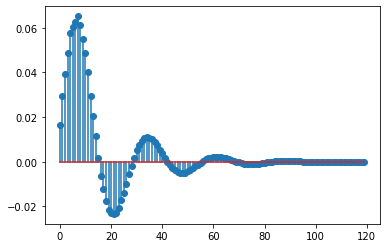

In [6]:
dK = np.array([1]+[0]*119)  # Kronecker delta
h_n = scipy.signal.lfilter([B[99]], a_i[99], dK, axis= -1, zi=None)  # impulse response 
plt.close('all')
plt.stem(range(120), h_n)

In [7]:
print(len(h_n))

120


### Conclusion part A:
The impulse response has length 120.

## Question b)

We will represent the same output (that is the 100th frame), but now we are asked to apply its corresponding excitement and gainth (that we can find at _sintesis.mat_ file, which we previously load). Let's see the output:

<StemContainer object of 3 artists>

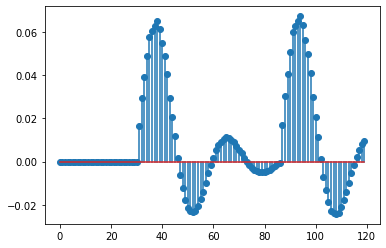

In [8]:
y_n = scipy.signal.lfilter([B[99]], a_i[99], x_n[99], axis= -1, zi=None)
plt.close('all')
plt.stem(range(120), y_n)

## Question c)

Finally, we will compute the total synthesis filtring all frames with its corresponding excitations and concatenating the outputs. Let's check what happens:

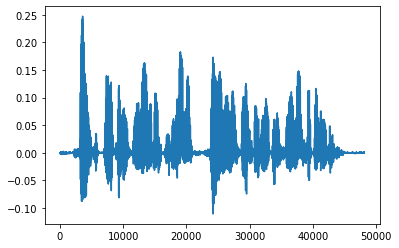

In [9]:
domain = range(120*401)
output = np.array([])
for n in range(401):
    output = np.append(output, scipy.signal.lfilter([B[n]], a_i[n], x_n[n], axis= -1, zi=None))

plt.close('all')
plt.plot(domain, output)

In [10]:
sd.play(output)

The output signal is quite short to be heard propperly, thus let output be rescaled for the sake of practicality:

In [11]:
output_r = rescale(output)
sd.play(output_r)

## Question d)

In [12]:
idxs = np.argwhere(output==0)
print("There are ", len(idxs), " points where output is zero.")
first_zero =  idxs[0,0]
print("The first index where output is zero: ", first_zero)

There are  4927  points where output is zero.
The first index where output is zero:  3360


In order to find out how many points of the signal have the value 0, we have used the command ```idxs = np.argwhere(output==0)```. It clearly shows that there are 4927 points where the output signal is 0.

Once having shown that, the next step is showing that there are some segments where the synthesized signal changes abruptly to 0 and other short ones which also take the value 0. To see that, we have projected a short segment (lenght 30) of the output signal that contains some 0 values:

<StemContainer object of 3 artists>

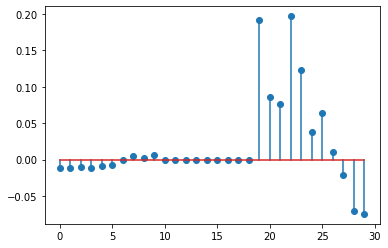

In [13]:
plt.close('all')
plt.stem(range(30), output[first_zero - 10:first_zero+20])

### Conclusion Part D:
In this example we can see that there is a secuence where the output is zero, and suddenly it changes to a higher value. If we repeat this for every zero secuence, we can see the changes on the signal.

## Question e)

To synthesize all the frames so that the output signal doesen't present the value 0 at any point, it is necessary a loop that, for each individual frame, its initial conditions ```zi``` are the final conditions ```zf```of the previous frame (setting the initial conditions of the first frame as an array of zeros).

In [14]:
output2 = np.array([])
zf = np.zeros(10)
for n in range(401):
    evaluate, zf = scipy.signal.lfilter([B[n]], a_i[n], x_n[n], axis= -1, zi=zf[-10:])
    output2 = np.append(output2, evaluate)

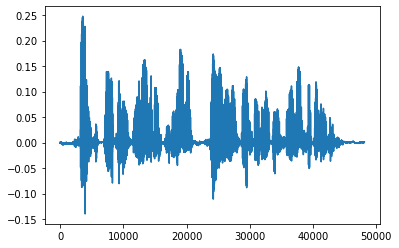

In [15]:
plt.close('all')
plt.plot(range(120*401), output2)

In [16]:
idxs = np.argwhere(output2==0)
print(len(idxs))

0


### Conclusion Part E:
It is shown by the last cell of code that there are 0 indexes where the output signal is zero.

## Question f)

Again, let output2 be rescaled:

In [17]:
output2_r = rescale(output2, interpolate=True)

In [18]:
sd.play(output_r)

In [19]:
sd.play(output2_r)

### Conclusion Part F
The first signal is of a such lower quality than the second one. This is because the output2 signal has been fedback with itself, and the union of the phonemes is smoother. Therefore, it sounds more clear.

# SECTION B: Excitation estimation

## Question a)

We know that the correlation of a signal tries to find the resemblance between this signal and itself shifted. Now we suppose we have a $f[n]$. Let us define its autocorrelation as $R_{ff}[n]$. Now, let's define the signal $s[n] = f[n] +f[n‐N]+f[n‐2N]$. We will demonstrate that its autocorrelation is $R_{ss}[m]= 3R_{ff}[m]+2R_{ff}[m ‐N]+2R_{ff}[m +N]+ R_{ff}[m ‐2N]+ R_{ff}[m +2N]$.
First of all, we should remember some theoretical concepts:
###### Definition of autocorrelation: 
$$R_{ss}[m]=\sum_{n=-\infty}^{\infty}s[n+m]s^*[n]=\sum_{n=-\infty}^{\infty}s[n]s^*[n-m]$$
###### Important to take into account:
We will perform many **change of variables** and we would like to recall that we are talking about "_variables mudas_ ", so, it does not affect on the definition of autocorrelation. 

$$\begin{align}
R_{ss}[m]&=\sum_{n=-\infty}^{\infty}s[n+m]s^*[n]=\sum_{n=-\infty}^{\infty}s[n]s^*[n-m]=\{{\text{by definition of }s[n]}\}\\
         &=\sum_{n=-\infty}^{\infty}\{\{f[n+m]+f[n+m-N]+f[n+m-2N]\}·\{f^*[n]+f^*[n-N]+f^*[n-2N]\}\}
\end{align}$$

where we will perform all different products (recalling what we said about the change of variables):

* $\sum_{n=-\infty}^{\infty}f[n+m]f^*[n]=R_{ff}[m]$
* $\sum_{n=-\infty}^{\infty}f[n+m]f^*[n-N]=\{\text{let }k=n-N\}=\sum_{n=-\infty}^{\infty}f[k+N+m]f^*[k]=R_{ff}[m+N]$
* $\sum_{n=-\infty}^{\infty}f[n+m]f^*[n-2N]=\{\text{let }k=n-2N\}=\sum_{n=-\infty}^{\infty}f[k+2N+m]f^*[k]=R_{ff}[m+2N]$
* $\sum_{n=-\infty}^{\infty}f[n+m-N]f^*[n]=R_{ff}[m-N]$
* $\sum_{n=-\infty}^{\infty}f[n+m-N]f^*[n-N]=\{\text{let }k=n-N\}=\sum_{n=-\infty}^{\infty}f[k+m]f^*[k]=R_{ff}[m]$
* $\sum_{n=-\infty}^{\infty}f[n+m-N]f^*[n-2N]=\{\text{let }k=n-2N\}=\sum_{n=-\infty}^{\infty}f[k+N+m]f^*[k]=R_{ff}[m+N]$
* $\sum_{n=-\infty}^{\infty}f[n+m-2N]f^*[n]=R_{ff}[m-2N]$
* $\sum_{n=-\infty}^{\infty}f[n+m-2N]f^*[n-N]=\{\text{let }k=n-N\}=\sum_{n=-\infty}^{\infty}f[k-N+m]f^*[k]=R_{ff}[m-N]$
* $\sum_{n=-\infty}^{\infty}f[n+m-2N]f^*[n-2N]=\{\text{let }k=n-2N\}=\sum_{n=-\infty}^{\infty}f[k+m]f^*[k]=R_{ff}[m]$

and adding all the past results we obtain:

$$R_{ss}[m]= 3R_{ff}[m]+2R_{ff}[m‐N]+2R_{ff}[m+N]+ R_{ff}[m‐2N]+ R_{ff}[m+2N]$$

$$\quad Q.E.D.$$

## Question b)

<StemContainer object of 3 artists>

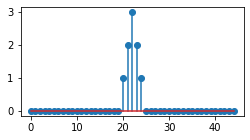

In [20]:
f = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
#plt.close('all')
#plt.figure(figsize=(4,2))
#plt.stem(range(len(x)), x)
Rff = correlate(f, f, 'full')
plt.close('all')
plt.figure(figsize=(4,2))
plt.stem(range(len(Rff)), Rff)

<StemContainer object of 3 artists>

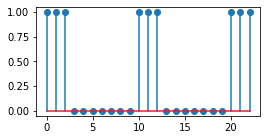

In [21]:
# n=5
f =    np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
f_N =  np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
f_2N = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

s = f + f_N + f_2N

plt.close('all')
plt.figure(figsize=(4,2))
plt.stem(range(len(s)), s)

<StemContainer object of 3 artists>

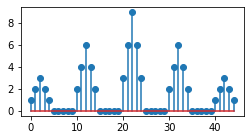

In [22]:
Rss = correlate(s, s, 'full')
plt.close('all')
plt.figure(figsize=(4,2))
plt.stem(range(len(Rss)), Rss)

## Question c)

In [113]:
def period(signal):
    Rss = correlate(signal, signal, 'full')
    origin = np.argmax(Rss)
    idxs = argrelextrema(Rss[origin:], np.greater)[0]
    N = idxs[np.argmax([Rss[origin+idx] for idx in idxs])]
    print(Rss[origin+N], Rss[origin-N])
    if Rss[origin+N] != Rss[origin-N]:
        return 0
    return N

In [114]:
y_n = scipy.signal.lfilter([B[99]], a_i[99], x_n[99], axis= -1, zi=None)
period(y_n)

0.03735898091002751 0.03735898091002751


56

<IPython.core.display.Javascript object>


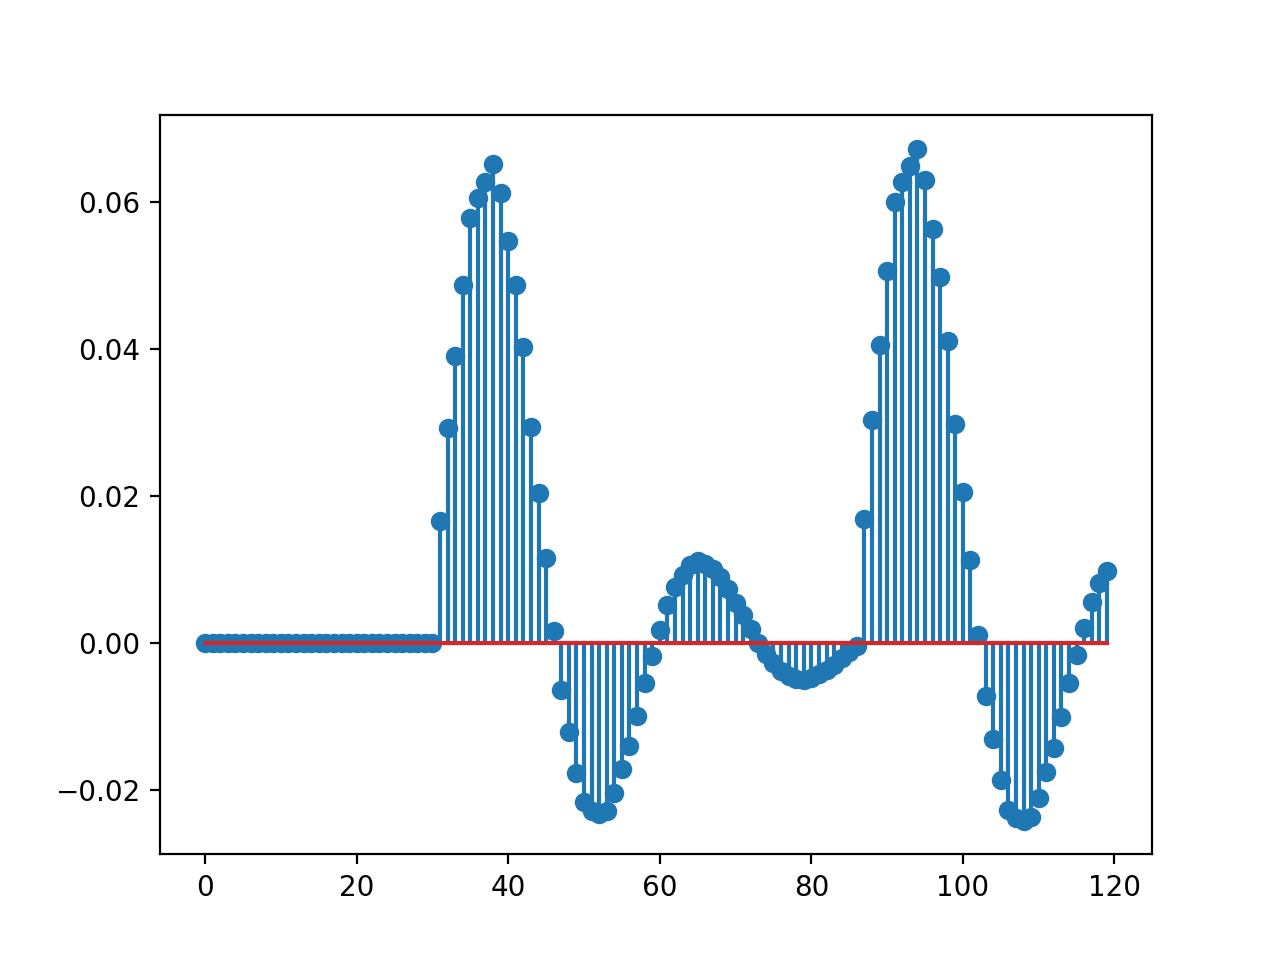

<StemContainer object of 3 artists>

In [107]:
plt.close('all')
plt.stem(y_n)

<IPython.core.display.Javascript object>


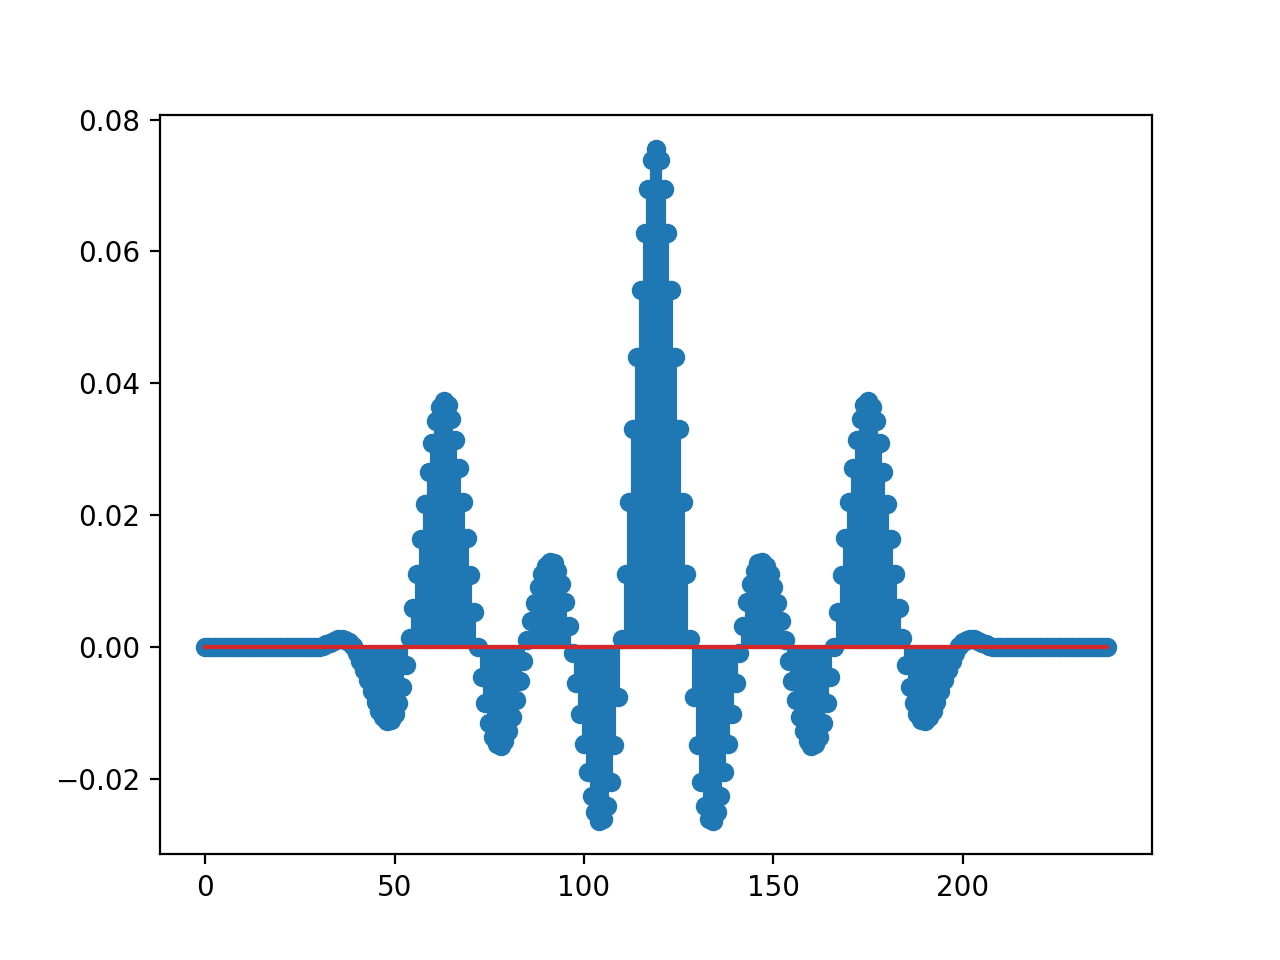

<StemContainer object of 3 artists>

In [109]:
Ryy = correlate(y_n, y_n, 'full')
plt.close('all')
plt.stem(Ryy)

In [123]:
soroll = scipy.signal.lfilter([B[7]], a_i[7], x_n[7], axis= -1, zi=None)
period(soroll)

0.00010301034866797286 0.00010301034866797286


3

<IPython.core.display.Javascript object>


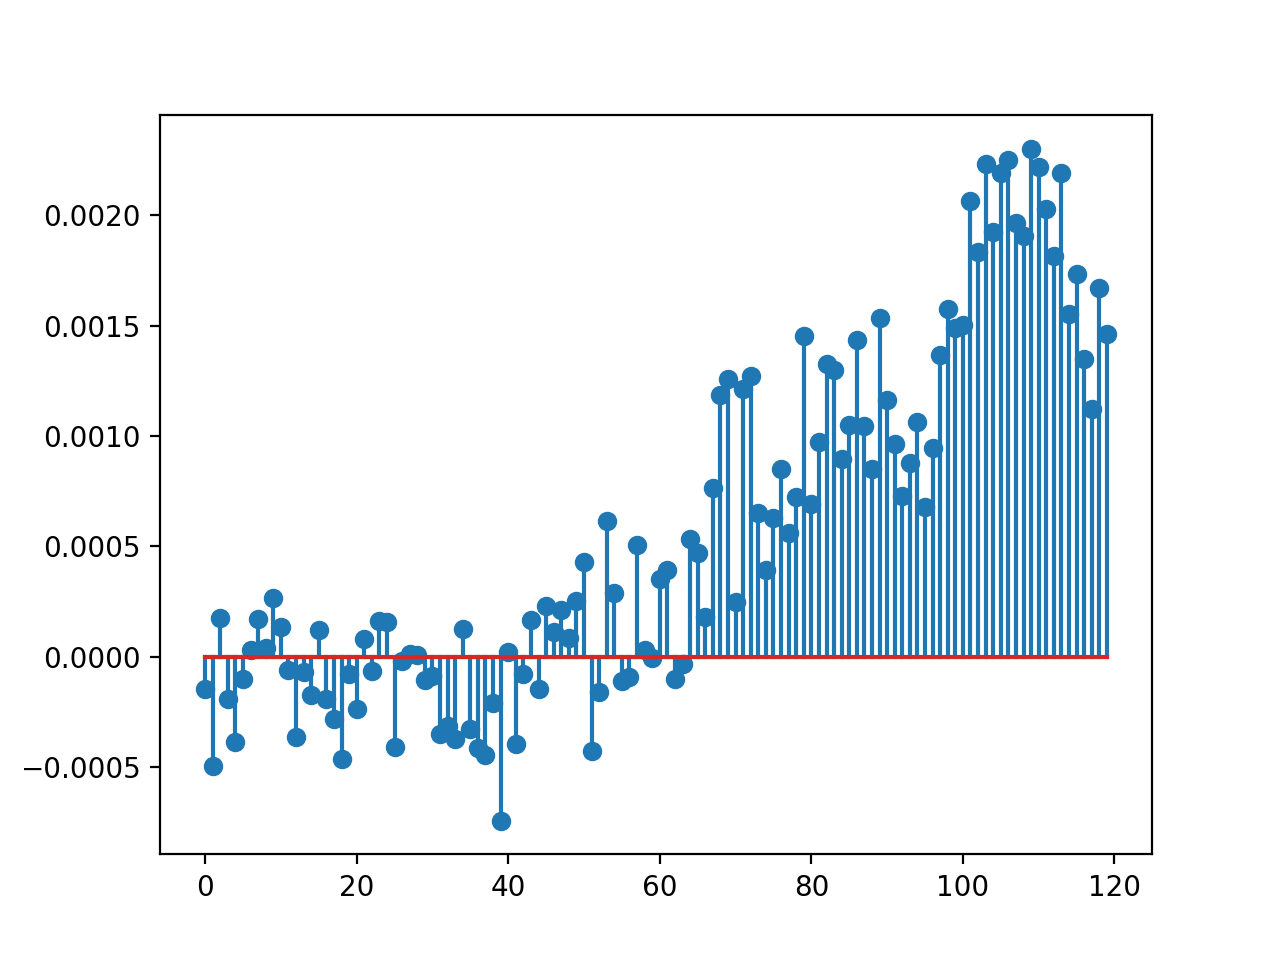

<StemContainer object of 3 artists>

In [124]:
plt.close('all')
plt.stem(soroll)

<IPython.core.display.Javascript object>


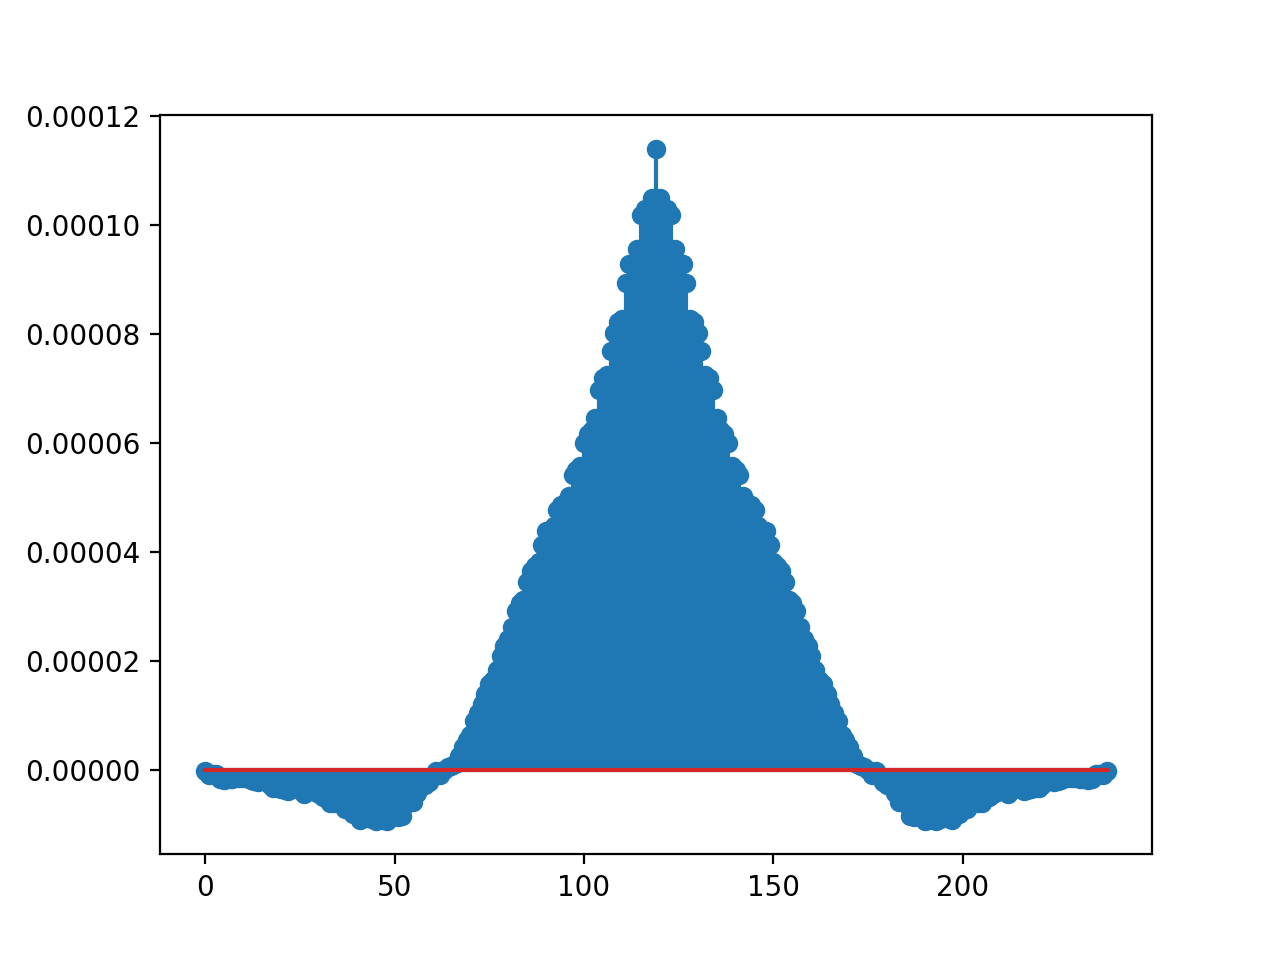

<StemContainer object of 3 artists>

In [127]:
Rss = correlate(soroll, soroll, 'full')
plt.close('all')
plt.stem(Rss)

# SECTION C: Synthetic signal modification